# Monitor Convergence for Run 6

Applying multiple convergence checks for run 6, which adopted a floating Y and alpha. Up to now, we have monitored convergence by visually inspecting trace plots. It would be useful to know if convergence has been obtained using other metrics.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Defining convergence diagnostics

(1) trace plot, (2) acceptance fraction, (3) Gelman-Rubin diagnostic, (4) autocorrelation, (5) moving average. Others to consider: Geweke diagnostic, Raferty-Lewis diagnostic, Heidelberg-Welch diagnostic, ...

In [2]:
def tracePlot(chains, labels=None, truths=None):
    n_dim = chains.shape[2]
    
    fig, ax = plt.subplots(n_dim, 1, figsize=(8., 27.), sharex=True)
    ax[-1].set_xlabel('Iteration', fontsize=20.)
    for i in range(len(ax)):
        try:
            ax[i].set_ylabel(labels[i], fontsize=20.)
        except IndexError:
            pass
        ax[i].tick_params(which='major', axis='both', length=10., labelsize=16.)
        for j in range(len(chains)):
            try:
                ax[i].plot([0, len(chains[j,:,i])+10], [truths[i], truths[i]], '-', lw=4, dashes=(20., 10.), 
                           c='#B22222')
            except:
                pass
            ax[i].plot(chains[j,:,i], '-', lw=1, c='#0473B3', alpha=0.5)
    fig.tight_layout()

In [3]:
def GelmanRubin(chains, labels=None):
    n_chains = chains.shape[0]
    n_iter   = chains.shape[1]/2
    n_params = chains.shape[2]
    
    # take last n samples if total was 2n
    sample = chains[:,-n_iter:,:]
    
    # compute mean of intra-chain (within) variances
    W = np.mean(np.var(sample, axis=1), axis=0)
    
    # compute mean of inter-chain (between) variances
    chain_means = np.mean(sample, axis=1)
    mean_of_chain_means = np.mean(chain_means, axis=0)
        
    B = np.empty(n_params)
    for i in range(n_params):
        B[i] = np.sum((chain_means[:, i] - mean_of_chain_means[i])**2)*n_iter/(n_chains - 1.)
    
    # estimated variance (likely an over-estimate)
    Sigma_hat_2 = ((n_iter - 1.)*W + B)/n_iter
    
    # pooled posterior variance
    Var_hat = Sigma_hat_2 + B/(n_chains*n_iter)
    
    # correction for degree of freedom
    
    # compute potential scale reduction factor
    PSRF = np.sqrt(Var_hat/W)
    
    return W, B, Var_hat, PSRF

## Process samples

In [4]:
# test with Gl 876, the largest number of iterations
flatchain = np.genfromtxt('/Users/grefe950/Software/StarBay/interbay/chains/run06/GJ876_W0300_N0600_B0000.dat')
chains = flatchain.reshape(300, -1, 9)
labels=['Mass', '[Fe/H]', 'Y', 'log(Age)', 'Distance', 'alpha', 'log(Teff)', 'log(Fbol)', 'theta']
truths = [np.nan, 0.17, np.nan, np.nan, 1./0.21328, np.nan, np.log10(3189.), np.log10(1.9156e-8), 0.746]

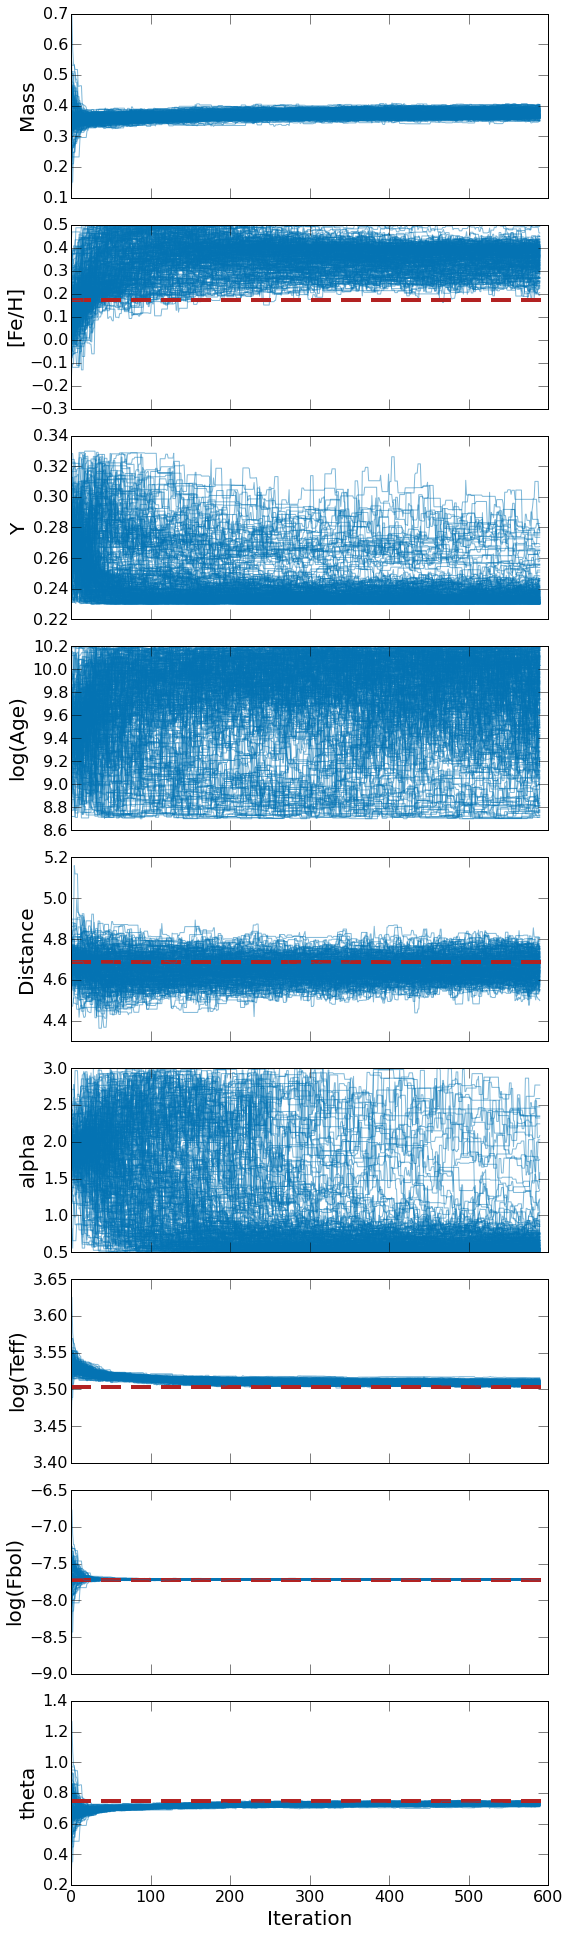

In [5]:
tracePlot(chains, labels=labels, truths=truths)

In [6]:
GelmanRubin(chains, labels=labels)

(array([  4.44585679e-05,   1.05904239e-03,   2.46260383e-05,
          3.59135662e-02,   1.37588719e-03,   3.05451711e-02,
          2.16210911e-06,   1.09053794e-05,   2.61210658e-05]),
 array([  2.87520697e-02,   6.00639537e-01,   3.95058028e-02,
          3.70394018e+01,   4.64464342e-01,   4.52953126e+01,
          1.23395312e-03,   1.41997816e-03,   1.26191538e-02]),
 array([  1.42097386e-04,   3.09830553e-03,   1.58906929e-04,
          1.61767644e-01,   2.95092675e-03,   1.84496872e-01,
          6.35161482e-06,   1.56979422e-05,   6.89519016e-05]),
 array([ 1.78778509,  1.71043057,  2.54023644,  2.12234784,  1.46449469,
         2.45766804,  1.71397022,  1.19977822,  1.62471682]))

Based on the trace plot, it seems as though the ensemble of chains have converged upon a solution. However, under the Gelman-Rubin diagnostic, the potential scale reduction factor is larger than one should like, that is, well above unity. In the trace plots, one can see that there are small systematic trends that are still present, as the chains are slowly converging toward a suitable solution. The one exception is the bolometric flux, which is reaching an acceptable level of convergence (~1.2).

It is therefore likely that we should continue running the chains further and continually apply a Gelman-Rubin diagnostic to assess the convergence of each parameter.